#### Plot of expected depreciation rates according to UIP approximation
This corresponds to the spread in net yields between countries

In [ ]:
# (Re)load data
import utils
from importlib import reload
reload(utils)
from utils import *

In [ ]:
# Plot of expected depreciation rates, starting July 2004
plot_data = spread_data[['REF_AREA','yield_spread']].copy()
plot_data = plot_data[~(plot_data['REF_AREA']).isin(
    ['DE','SE', 'FR', 'ES'] # countries to exclude
)]
plot_data.sort_values(by='REF_AREA',inplace=True)
plot_data.sort_index(inplace=True)

display(spread_data.head())

px.line(
    plot_data,
    y='yield_spread',
    line_group='REF_AREA',
    color='REF_AREA',
    labels={
        'TIME_PERIOD' : 'Time',
        'yield_spread' : 'Percentage point difference',
        'REF_AREA' : 'Country',
    },
    title='Spread btw domestic (+) and US (-) yields',
)

#### Plots of Nominal and real ERs vs trade as % of gdp

In [227]:
#import utils
from importlib import reload
reload(utils)
from utils import *

There are in total
0 series which do not have
the 6 digit unit multiplier.
Yields are present for the following countries: 
GB, AU, CA, CH, CL, DE, ES, I9, FR, IL, JP, KR, MX, NZ, SE, US, ZA
Only considering these ones in the analysis (data on other countries will be dropped.)


In [ ]:
# Pivot goods table
import plotly.express as px
import pandas as pd

# Recreate aligned tables for Trade data
def pivot_goods_trade(df : pd.DataFrame, cnt_area : str) -> pd.DataFrame:
    exports_all = df.copy()
    exports_all = exports_all[exports_all['INDICATOR']=='Exports FOB (USD)']
    exports_all = exports_all[exports_all['CNT_AREA']==cnt_area]
    exports_all = exports_all[['REF_AREA', 'OBS_VALUE']]
    exports_all.columns = ['REF_AREA', 'Goods Exports FOB']

    imports_all = df.copy()
    imports_all = imports_all[imports_all['INDICATOR']=='Imports CIF (USD)']
    imports_all = imports_all[imports_all['CNT_AREA']==cnt_area]
    imports_all = imports_all[['REF_AREA', 'OBS_VALUE']]
    imports_all.columns = ['REF_AREA', 'Goods Imports CIF']

    tb = df.copy()
    tb = tb[tb['INDICATOR']=='Trade balance (USD)']
    tb = tb[tb['CNT_AREA']==cnt_area]
    tb = tb[['REF_AREA', 'OBS_VALUE']]
    tb.columns = ['REF_AREA', 'Goods Trade Balance']

    interim = pd.merge(
        exports_all.reset_index(), 
        imports_all.reset_index(),
        'inner', on=['TIME_PERIOD', 'REF_AREA']
        )
    final = pd.merge(
        interim, 
        tb.reset_index(),
        'inner', on=['TIME_PERIOD', 'REF_AREA']
        )
    final.set_index('TIME_PERIOD', inplace=True)
    return final

trade_goods_all = pivot_goods_trade(trade_goods, 'W1')

In [229]:
# Pivot services table
trade_services.index = trade_services.index.astype(float).astype(int)
def pivot_services_trade(df : pd.DataFrame, cnt_area : str) -> pd.DataFrame:
    export_services = df.copy()
    export_services = export_services[export_services['ACCOUNTING_ENTRY']=="C"]
    export_services = export_services[export_services['COUNTERPART_AREA']==cnt_area]
    export_services = export_services[['REF_AREA', 'OBS_VALUE']]
    export_services.columns = ['REF_AREA', 'Services Exports']

    import_services = df.copy()
    import_services = import_services[import_services['ACCOUNTING_ENTRY']=="D"]
    import_services = import_services[import_services['COUNTERPART_AREA']==cnt_area]
    import_services = import_services[['REF_AREA', 'OBS_VALUE']]
    import_services.columns = ['REF_AREA', 'Services Imports']

    tb = df.copy()
    tb = tb[tb['ACCOUNTING_ENTRY']=="B"]
    tb = tb[tb['COUNTERPART_AREA']==cnt_area]
    tb = tb[['REF_AREA', 'OBS_VALUE']]
    tb.columns = ['REF_AREA', 'Services Trade Balance']
 
    interim = pd.merge(
        export_services.reset_index(), 
        import_services.reset_index(),
        'inner', on=['TIME_PERIOD', 'REF_AREA']
        )
    final = pd.merge(
        interim, 
        tb.reset_index(),
        'inner', on=['TIME_PERIOD', 'REF_AREA']
        )
    final.set_index('TIME_PERIOD', inplace=True)
    return final

trade_services_all = pivot_services_trade(trade_services, "W1")

In [230]:
# Need to sum goods trade by year for consistency:
# make it comparable with OBS_VALUE for services

trade_goods_all_worker = trade_goods_all.copy()
trade_goods_all_worker.reset_index(inplace=True)
trade_goods_all_worker['TIME_PERIOD'] = trade_goods_all_worker['TIME_PERIOD'].apply(lambda x : x[:4])
trade_goods_all_worker = trade_goods_all_worker.groupby(["REF_AREA","TIME_PERIOD"]).sum().reset_index().set_index("TIME_PERIOD")
trade_goods_all_worker.index = trade_goods_all_worker.index.astype(float).astype(int)

all_trade = pd.merge(
    trade_goods_all_worker.reset_index(),
    trade_services_all.reset_index(),
    'inner', on=['REF_AREA','TIME_PERIOD']
).set_index("TIME_PERIOD")

# Now sum trade values across goods and services
# Also need to divide goods by 1e6 since services is in millions
all_trade['All exports']   = all_trade["Goods Exports FOB"] / 1e6 + all_trade["Services Exports"]
all_trade['All imports']   = all_trade["Goods Imports CIF"] / 1e6 + all_trade["Services Imports"]
all_trade['Trade balance'] = all_trade["Goods Trade Balance"] / 1e6 + all_trade["Services Trade Balance"]

all_trade = all_trade[["REF_AREA", "All exports", "All imports", "Trade balance"]]
all_trade.sort_index(inplace=True)
px.line(
    all_trade, y='Trade balance',
    color="REF_AREA", labels = {
        "TIME_PERIOD" : "Time",
        "REF_AREA" : "Country"
    }, title="Evolution of trade balances over time")

In [ ]:
# Now plot scatter with ERs. Need to create annual series
allspotsinusd.index.name = 'TIME_PERIOD'
flat_spots = pd.melt(allspotsinusd.reset_index(),id_vars='TIME_PERIOD')
flat_spots = flat_spots.replace("I9","EU") # so we get some sort of comparison
flat_spots.columns = ['TIME_PERIOD', 'REF_AREA', 'OBS_VALUE_spot']
flat_spots['TIME_PERIOD'] = flat_spots['TIME_PERIOD'].apply(lambda date : date[:4])
flat_spots = flat_spots.groupby(["TIME_PERIOD", "REF_AREA"]).median().sort_values(["REF_AREA", "TIME_PERIOD"])
flat_spots["OBS_VALUE_USappr_rate"] = (
    flat_spots.groupby("REF_AREA")["OBS_VALUE_spot"]
    .pct_change())
flat_spots.reset_index(inplace=True)
flat_spots.dropna(how="any",axis=0)
flat_spots.set_index("TIME_PERIOD", inplace=True)
flat_spots.index = flat_spots.index.astype(float).astype(int)

er_with_trade = pd.merge(
    flat_spots.reset_index(), all_trade.reset_index(),
    'inner', on=['TIME_PERIOD','REF_AREA']
)

px.scatter(
    er_with_trade,
    x="OBS_VALUE_USappr_rate",
    y="All exports",
    color="REF_AREA",
    labels={
        "OBS_VALUE_USappr_rate" : "Foreign currency depreciation v. USD.",
        "REF_AREA" : "Country"
    })

In [ ]:
# Wish to construct measure of openness and scale it by GDP
gdp_worker = gdp.copy()
gdp_worker['TIME_PERIOD'] = gdp_worker['TIME_PERIOD'].apply(lambda x : x[:4])
gdp_worker = gdp_worker.groupby(["REF_AREA", "Country", "TIME_PERIOD"]).mean()
gdp_worker.reset_index(inplace=True)
gdp_worker.set_index("TIME_PERIOD", inplace=True)
gdp_worker.index = gdp_worker.index.astype(int)

full_annual = pd.merge(
    gdp_worker.reset_index(), er_with_trade,
    'inner', on=['TIME_PERIOD','REF_AREA']
)

full_annual["Openness"] = (abs(full_annual["All exports"]) + abs(full_annual["All imports"])) / abs(full_annual["OBS_VALUE_gdp"])
full_annual.head()

,TIME_PERIOD,REF_AREA,Country,OBS_VALUE_gdp,OBS_VALUE_spot,OBS_VALUE_USappr_rate,All exports,All imports,Trade balance,Openness
0,1999,AU,Australia,492228.250,1.547509,NaN,74990.755858,91694.168570,-16703.412712,0.338633
1,2000,AU,Australia,523906.275,1.708818,0.104238,83637.015421,91536.887680,-7899.872259,0.334361
2,2001,AU,Australia,550254.450,1.938172,0.134218,81700.659212,82479.958229,-779.299017,0.298372
3,2002,AU,Australia,585379.600,1.831502,-0.055037,85294.283397,92869.015353,-7574.731956,0.304355
4,2003,AU,Australia,614027.275,1.523926,-0.167937,95398.708584,112829.867661,-17431.159077,0.339119


In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

dep_var = 'All imports'

def plot_scatter(area):
    data = full_annual[full_annual['REF_AREA'] == area].dropna(subset=['OBS_VALUE_USappr_rate', dep_var])
    x, y = data[dep_var], data['OBS_VALUE_USappr_rate']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.6)
    plt.plot(x, p(x), 'r-', linewidth=2)
    plt.xlabel('Trade Balance')
    plt.ylabel('US Appreciation Rate')
    plt.title(f'{area}: US Appreciation Rate vs {dep_var}')
    plt.grid(True, alpha=0.3)
    plt.show()

widgets.interact(plot_scatter, area=widgets.Dropdown(options=sorted(full_annual['REF_AREA'].unique()), description='Country:'))

interactive(children=(Dropdown(description='Country:', options=('AU', 'CA', 'CH', 'JP', 'KR', 'MX', 'NZ'), val…

<function __main__.plot_scatter(area)>

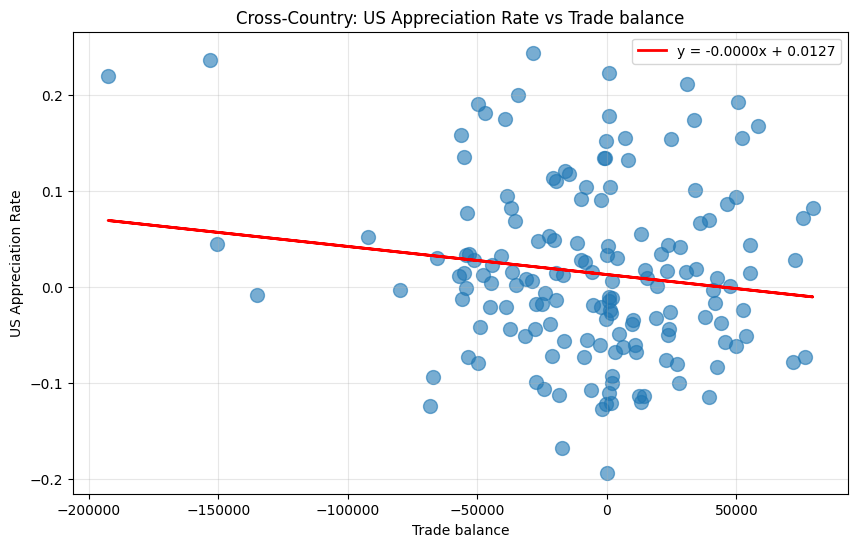

In [259]:
# Cross-country scatter: consider all observations together
all_together = full_annual.copy()
all_together = all_together[[dep_var, 'OBS_VALUE_USappr_rate']].dropna()
x, y = all_together[dep_var], all_together['OBS_VALUE_USappr_rate']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6, s=100)
plt.plot(x, p(x), 'r-', linewidth=2, label=f'y = {z[0]:.4f}x + {z[1]:.4f}')
plt.xlabel(dep_var)
plt.ylabel('US Appreciation Rate')
plt.title(f'Cross-Country: US Appreciation Rate vs {dep_var}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

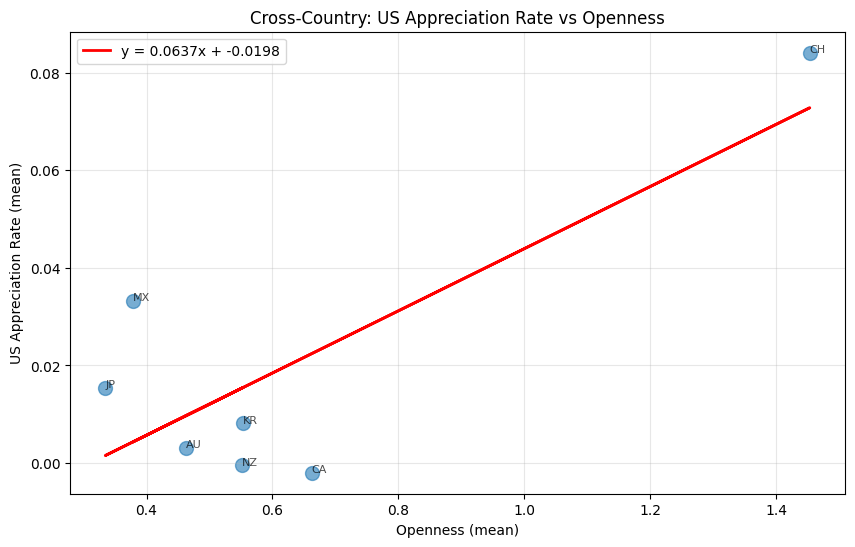

In [ ]:
# Cross-country scatter: each country is one observation (time-averaged)
country_means = full_annual.groupby('REF_AREA')[['OBS_VALUE_USappr_rate',dep_var]].mean().dropna()
x, y = country_means[dep_var], country_means['OBS_VALUE_USappr_rate']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6, s=100)
for area in country_means.index:
    plt.annotate(area, (country_means.loc[area, dep_var], country_means.loc[area, 'OBS_VALUE_USappr_rate']), 
                 fontsize=8, alpha=0.7)
plt.plot(x, p(x), 'r-', linewidth=2, label=f'y = {z[0]:.4f}x + {z[1]:.4f}')
plt.xlabel(f'{dep_var} (mean)')
plt.ylabel('US Appreciation Rate (mean)')
plt.title(f'Cross-Country: US Appreciation Rate vs {dep_var}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Obtain openness to trade specifically with the US to see
# what level of penetration they have
trade_goods_US = pivot_goods_trade(trade_goods, 'US')
trade_services_US = pivot_services_trade(trade_services, "US")

trade_goods_US_worker = trade_goods_US.copy()
trade_goods_US_worker.reset_index(inplace=True)
trade_goods_US_worker['TIME_PERIOD'] = trade_goods_US_worker['TIME_PERIOD'].apply(lambda x : x[:4])
trade_goods_US_worker = trade_goods_US_worker.groupby(["REF_AREA","TIME_PERIOD"]).sum().reset_index().set_index("TIME_PERIOD")
trade_goods_US_worker.index = trade_goods_US_worker.index.astype(float).astype(int)

trade_w_US = pd.merge(
    trade_goods_US_worker.reset_index(),
    trade_services_US.reset_index(),
    'inner', on=['REF_AREA','TIME_PERIOD']
).set_index("TIME_PERIOD")

# Now sum trade values across goods and services
# Also need to divide goods by 1e6 since services is in millions
trade_w_US['All exports']   = trade_w_US["Goods Exports FOB"] / 1e6 + trade_w_US["Services Exports"]
trade_w_US['All imports']   = trade_w_US["Goods Imports CIF"] / 1e6 + trade_w_US["Services Imports"]
trade_w_US['Trade balance'] = trade_w_US["Goods Trade Balance"] / 1e6 + trade_w_US["Services Trade Balance"]

trade_w_US_worker = trade_w_US.copy()
all_trade_worker  = all_trade.copy()
trade_w_US_worker = trade_w_US_worker[[
    "REF_AREA","All exports", "All imports", "Trade balance"
]]
all_trade_worker = all_trade_worker[[
    "REF_AREA","All exports", "All imports", "Trade balance"
]]

us_penetration = pd.merge(
    trade_w_US_worker.reset_index(),
    all_trade_worker.reset_index(),
    'inner', on=['TIME_PERIOD', "REF_AREA"]
).sort_values(["REF_AREA","TIME_PERIOD"]).set_index("TIME_PERIOD")

us_penetration['US penetration'] = (
    (abs(us_penetration['All exports_x']) + \
    abs(us_penetration['All imports_x'])) / \
        (abs(us_penetration['All exports_y']) +
        abs(us_penetration['All imports_y']))
    )

us_penetration.columns = [
    "REF_AREA", "US exports", "US imports",
    "Trade balance with US", 
    "All exports","All imports","Trade balance",
    "US penetration"]

us_penetration.reset_index().sort_values(["TIME_PERIOD","US penetration"], ascending = False).head()

,TIME_PERIOD,REF_AREA,US exports,US imports,Trade balance with US,All exports,All imports,Trade balance,US penetration
98,2024,JP,198563.596579,160642.541552,37920.955027,9.355477e+05,9.894596e+05,-53911.936366,0.186600
87,2024,GB,248744.533159,150885.048117,97859.485042,1.113468e+06,1.134507e+06,-21038.716376,0.177773
125,2024,KR,160484.508000,111740.870000,48743.638000,8.225988e+05,7.944100e+05,28188.875000,0.168351
144,2024,NZ,9716.858849,7454.938208,2261.920641,6.139534e+04,6.697370e+04,-5578.367968,0.133769
24,2024,AU,26044.074312,62892.162357,-36848.088045,4.249980e+05,4.094890e+05,15509.006294,0.106576


In [286]:
px.line(
    us_penetration[us_penetration["REF_AREA"]!="CA"],
    y="US penetration",
    color="REF_AREA"
)